In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp
from numpy.polynomial.hermite import hermgauss

import vb_lib.structure_optimization_lib as s_optim_lib
from vb_lib import structure_model_lib, data_utils, cavi_lib, plotting_utils
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul


from bnpmodeling_runjingdev import log_phi_lib
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import influence_lib, modeling_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib
import bnpmodeling_runjingdev.influence_lib 

import re

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

In [3]:
foo = np.load('../fits/fits_20201122/huang2011_fit_alpha6.0_lrderivatives.npz')
for k in foo.files: 
    print(k)

vb_opt
alpha0
kl
dinput_dalpha
lr_time_alpha
logit_v_grid
influence_grid
dinput_dfun_worst-case
lr_time_worst-case
dinput_dfun_sigmoidal
lr_time_sigmoidal
dinput_dfun_sigmoidal_neg
lr_time_sigmoidal_neg
dinput_dfun_alpha_pert_pos
lr_time_alpha_pert_pos
dinput_dfun_alpha_pert_neg
lr_time_alpha_pert_neg


# Load data

In [4]:
# data_file = '../simulated_data/simulated_structure_data_nobs20_nloci50_npop4.npz'

data_file='/accounts/grad/runjing_liu/BNP/fastStructure/hgdp_data/' + \
            'huang2011_plink_files/phased_HGDP+India+Africa_2810SNPs-regions1to36.npz'

data = np.load(data_file)
g_obs = np.array(data['g_obs'], dtype = int)

In [5]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

In [6]:
print(n_obs)
print(n_loci)

1107
2810


# file paths

In [7]:
fits_dir = '../fits/fits_20201122/' 

filenames = 'huang2011_fit'
alpha0 = 6.0

init_fit_file = fits_dir + filenames + '_alpha' + str(alpha0) + '.npz'
lr_file = fits_dir + filenames + '_alpha' + str(alpha0) + '_lrderivatives.npz'

# fits_dir = '../fits/fits_20201122/'
# filename = fits_dir + 'huang2011_fit_alpha6.0.npz'

# Load initial fit for its metadata

In [8]:
print('initial fit file: ', init_fit_file)

vb_opt_dict, vb_params_paragami, \
        prior_params_dict, prior_params_paragami, \
            gh_loc, gh_weights, init_fit_meta_data = \
                structure_model_lib.load_structure_fit(init_fit_file)

alpha0 = prior_params_dict['dp_prior_alpha']
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

print('Init optim time: {:.3f}secs'.format(init_fit_meta_data['optim_time']))

initial fit file:  ../fits/fits_20201122/huang2011_fit_alpha6.0.npz
Init optim time: 9635.051secs


# Function to load all results

In [9]:
def get_free_params_from_lr_and_refit(perturbation):     
    
    #################
    # load linear response derivatives
    #################
    print('loading derivatives from: ', lr_file)
    lr_data = np.load(lr_file)
    assert lr_data['alpha0'] == alpha0
    assert np.all(lr_data['vb_opt'] == vb_opt)
    assert np.abs(lr_data['kl'] - init_fit_meta_data['final_kl']) < 1e-8
    
    ##################
    # load refit results
    ##################
    # get all files for that particular perturbation
    match_crit = filenames + '_' + perturbation + '\d+.npz'
    refit_files = [f for f in os.listdir(fits_dir) if re.match(match_crit, f)]
    
    assert len(refit_files) > 0, 'no refit files found'
    
    # load files
    optim_time_vec = [init_fit_meta_data['optim_time']]
    epsilon_vec = [0.]
    vb_refit_list = [vb_opt]

    for i in range(len(refit_files)): 

        print('loading fit from: ', refit_files[i])
        vb_params_dict, vb_params_paragami, meta_data = \
            paragami.load_folded(fits_dir + refit_files[i])
        
        optim_time_vec.append(meta_data['optim_time'])
        epsilon_vec.append(meta_data['epsilon'])
        vb_refit_list.append(vb_params_paragami.flatten(vb_params_dict, free = True))
    
    optim_time_vec = np.array(optim_time_vec)
    epsilon_vec = np.array(epsilon_vec)
    vb_refit_list = np.array(vb_refit_list)
    
    # sort the epsilons 
    _indx = np.argsort(epsilon_vec)
    optim_time_vec = optim_time_vec[_indx]
    epsilon_vec = epsilon_vec[_indx]
    vb_refit_list = vb_refit_list[_indx]
    
    print('Derivative time: {:.3f}secs'.format(lr_data['lr_time_' + perturbation]))
    print('Optim time at epsilon = 1: {:.3f}secs'.format(optim_time_vec[-1]))
    
    ###############
    # get linear response predictions 
    ###############
    def predict_opt_par_from_hyper_par(epsilon): 
        return vb_opt + lr_data['dinput_dfun_' + perturbation] * epsilon
    
    lr_list = []
    for epsilon in epsilon_vec: 
        # get linear response
        lr_list.append(predict_opt_par_from_hyper_par(epsilon))
    
    return vb_refit_list, np.array(lr_list), optim_time_vec, epsilon_vec

# Define number of clusters

In [10]:
def g(vb_free_params, vb_params_paragami): 
    
    # key for random sampling. 
    # this is fixed! so all standard normal 
    # samples used in computing the posterior quantity 
    key = jax.random.PRNGKey(0)
    
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    return structure_model_lib.get_e_num_pred_clusters(stick_means, stick_infos, gh_loc, gh_weights, 
                                                       key = key,
                                                       n_samples = 1000)

# Functions to plot results

In [11]:
from tqdm import tqdm

In [12]:
def plot_lr_results(perturbation, ax): 
    # get free parameters
    vb_refit_list, lr_list, optim_time_vec, epsilon_vec = \
        get_free_params_from_lr_and_refit(perturbation)
    
    # get expected number of clusters
    print('Computing expected number of clusters ... ')
    lr_e_num_clusters_vec = onp.zeros(len(epsilon_vec))
    refit_e_num_clusters_vec = onp.zeros(len(epsilon_vec))

    for i in tqdm(range(len(epsilon_vec))): 
        refit_e_num_clusters_vec[i] = g(vb_refit_list[i], vb_params_paragami)
        lr_e_num_clusters_vec[i] = g(lr_list[i], vb_params_paragami)
    
    # plot
    ax.plot(epsilon_vec, refit_e_num_clusters_vec, 
           'o-', color = '#d95f02', label = 'refit')

    ax.plot(epsilon_vec, lr_e_num_clusters_vec, 
               'o-', color = '#1b9e77', 
               label = 'linear approx.')

    ax.legend()
    
    return vb_refit_list, lr_list, optim_time_vec, epsilon_vec

In [13]:
def plot_perturbation(perturbation, ax0, ax1): 
    
    lr_data = np.load(lr_file)
    logit_v_grid = np.array(lr_data['logit_v_grid'])
        
    if perturbation == 'worst-case': 
        # load influence function 
        print('Loading influence function from: ', lr_file)
        influence_grid = np.array(lr_data['influence_grid'])
        
        # get worst-case perturbation 
        worst_case_pert = influence_lib.WorstCasePerturbation(influence_fun = None, 
                                                      logit_v_grid = logit_v_grid, 
                                                      cached_influence_grid = influence_grid)
        
        # interpolate influence function w step functions
        def influence_fun_interp(logit_v): 
            # find index of logit_v_grid 
            # closest (on the left) to logit_v
            indx = np.searchsorted(worst_case_pert.logit_v_grid, logit_v)

            # return the influence function at those points
            return worst_case_pert.influence_grid[indx]

        # define log phi
        def log_phi(logit_v):
            return(np.sign(influence_fun_interp(logit_v)) * worst_case_pert.delta)
    else: 
        _log_phi = getattr(log_phi_lib, perturbation)
    
        # there has to be a better way ... 
        if (perturbation == 'alpha_pert_pos') or \
            (perturbation == 'alpha_pert_neg'): 
            log_phi = lambda x : _log_phi(x, prior_params_dict['dp_prior_alpha'])
        else: 
            log_phi = _log_phi 
        
    prior_perturbation = func_sens_lib.PriorPerturbation(
                                    alpha0 = prior_params_dict['dp_prior_alpha'],
                                    log_phi = log_phi, 
                                    logit_v_ub = 10, 
                                    logit_v_lb = -10)
    
    # plot log-phi
    ax0.plot(logit_v_grid, 
             prior_perturbation.log_phi(logit_v_grid), 
             color = 'grey')
    ax0.set_title('log phi in logit space')
    
    # plot priors
    ax1.plot(logit_v_grid, 
             np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)), 
             color = '#a6cee3', label = 'p0')
    ax1.plot(logit_v_grid, 
             np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)), 
             color = '#1f78b4', label = 'p1')
    ax1.set_title('priors in logit space')
    ax1.legend()

# Finally make plots!

In [14]:
def plot_stuff(perturbation): 
    
    fig, ax = plt.subplots(1, 3, figsize = (15, 4)) 
    
    # plot lr vs refit results
    vb_refit_list, lr_list, optim_time_vec, epsilon_vec = \
        plot_lr_results(perturbation, ax[2])
    
    # plot functional perturbation
    plot_perturbation(perturbation, ax[0], ax[1])
    
    # labels and such
    ax[0].set_xlabel('logit v')
    ax[0].set_ylabel('log phi')

    ax[1].set_xlabel('logit v')

    ax[2].set_xlabel('Epsilon')
    ax[2].set_ylabel('Expected #clusters')

    fig.tight_layout()
    
    return vb_refit_list, lr_list, optim_time_vec, epsilon_vec

loading derivatives from:  ../fits/fits_20201122/huang2011_fit_alpha6.0_lrderivatives.npz
loading fit from:  huang2011_fit_worst-case2.npz
loading fit from:  huang2011_fit_worst-case5.npz
loading fit from:  huang2011_fit_worst-case4.npz
loading fit from:  huang2011_fit_worst-case3.npz
loading fit from:  huang2011_fit_worst-case0.npz
loading fit from:  huang2011_fit_worst-case7.npz
loading fit from:  huang2011_fit_worst-case10.npz
loading fit from:  huang2011_fit_worst-case9.npz
loading fit from:  huang2011_fit_worst-case8.npz
loading fit from:  huang2011_fit_worst-case6.npz
loading fit from:  huang2011_fit_worst-case1.npz


  0%|          | 0/12 [00:00<?, ?it/s]

Derivative time: 1337.397secs
Optim time at epsilon = 1: 5158.961secs
Computing expected number of clusters ... 


100%|██████████| 12/12 [00:50<00:00,  4.17s/it]


Loading influence function from:  ../fits/fits_20201122/huang2011_fit_alpha6.0_lrderivatives.npz


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/scipy/integrate/quadrature.py:249: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.967512e-03
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/scipy/integrate/quadrature.py:249: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.752151e-01
  warnings.warn(


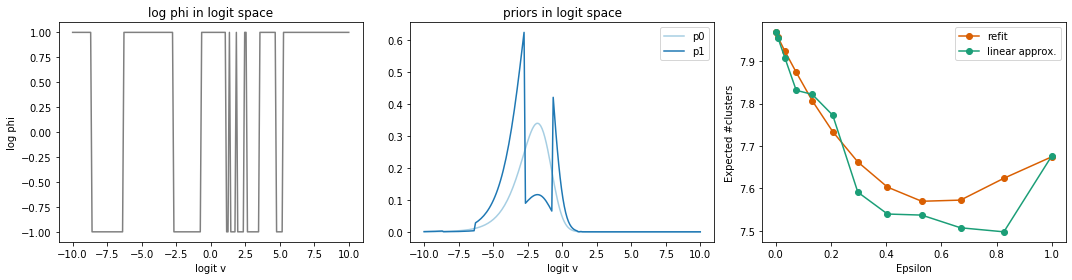

In [15]:
plot_stuff('worst-case');

loading derivatives from:  ../fits/fits_20201122/huang2011_fit_alpha6.0_lrderivatives.npz
loading fit from:  huang2011_fit_sigmoidal5.npz
loading fit from:  huang2011_fit_sigmoidal2.npz
loading fit from:  huang2011_fit_sigmoidal3.npz
loading fit from:  huang2011_fit_sigmoidal4.npz
loading fit from:  huang2011_fit_sigmoidal9.npz
loading fit from:  huang2011_fit_sigmoidal7.npz
loading fit from:  huang2011_fit_sigmoidal10.npz
loading fit from:  huang2011_fit_sigmoidal0.npz
loading fit from:  huang2011_fit_sigmoidal1.npz
loading fit from:  huang2011_fit_sigmoidal6.npz
loading fit from:  huang2011_fit_sigmoidal8.npz
Derivative time: 1359.645secs
Optim time at epsilon = 1: 1847.836secs


  0%|          | 0/12 [00:00<?, ?it/s]

Computing expected number of clusters ... 


100%|██████████| 12/12 [00:49<00:00,  4.12s/it]


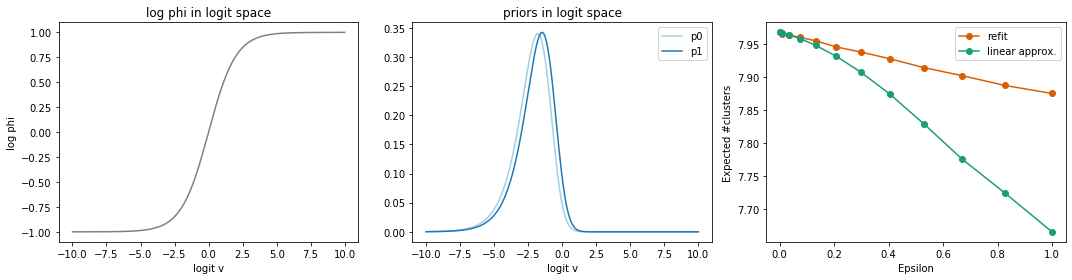

In [16]:
plot_stuff('sigmoidal');

loading derivatives from:  ../fits/fits_20201122/huang2011_fit_alpha6.0_lrderivatives.npz
loading fit from:  huang2011_fit_sigmoidal_neg10.npz
loading fit from:  huang2011_fit_sigmoidal_neg7.npz
loading fit from:  huang2011_fit_sigmoidal_neg0.npz
loading fit from:  huang2011_fit_sigmoidal_neg9.npz
loading fit from:  huang2011_fit_sigmoidal_neg8.npz
loading fit from:  huang2011_fit_sigmoidal_neg1.npz
loading fit from:  huang2011_fit_sigmoidal_neg6.npz
loading fit from:  huang2011_fit_sigmoidal_neg5.npz
loading fit from:  huang2011_fit_sigmoidal_neg2.npz
loading fit from:  huang2011_fit_sigmoidal_neg3.npz
loading fit from:  huang2011_fit_sigmoidal_neg4.npz
Derivative time: 1378.181secs
Optim time at epsilon = 1: 4194.441secs


  0%|          | 0/12 [00:00<?, ?it/s]

Computing expected number of clusters ... 


100%|██████████| 12/12 [00:49<00:00,  4.12s/it]


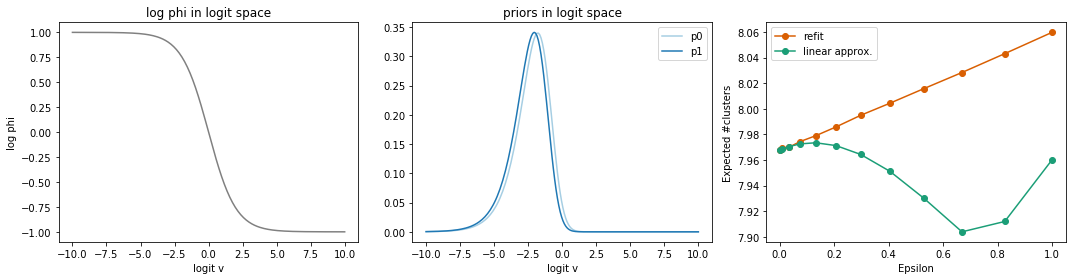

In [17]:
plot_stuff('sigmoidal_neg');

loading derivatives from:  ../fits/fits_20201122/huang2011_fit_alpha6.0_lrderivatives.npz
loading fit from:  huang2011_fit_alpha_pert_pos1.npz
loading fit from:  huang2011_fit_alpha_pert_pos6.npz
loading fit from:  huang2011_fit_alpha_pert_pos8.npz
loading fit from:  huang2011_fit_alpha_pert_pos9.npz
loading fit from:  huang2011_fit_alpha_pert_pos7.npz
loading fit from:  huang2011_fit_alpha_pert_pos0.npz
loading fit from:  huang2011_fit_alpha_pert_pos3.npz
loading fit from:  huang2011_fit_alpha_pert_pos4.npz
loading fit from:  huang2011_fit_alpha_pert_pos5.npz
loading fit from:  huang2011_fit_alpha_pert_pos2.npz
loading fit from:  huang2011_fit_alpha_pert_pos10.npz
Derivative time: 1259.123secs
Optim time at epsilon = 1: 3031.156secs


  0%|          | 0/12 [00:00<?, ?it/s]

Computing expected number of clusters ... 


100%|██████████| 12/12 [00:49<00:00,  4.10s/it]


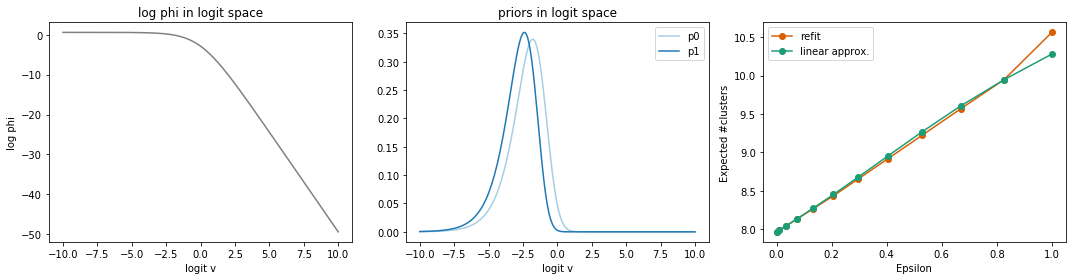

In [18]:
plot_stuff('alpha_pert_pos');

loading derivatives from:  ../fits/fits_20201122/huang2011_fit_alpha6.0_lrderivatives.npz
loading fit from:  huang2011_fit_alpha_pert_neg2.npz
loading fit from:  huang2011_fit_alpha_pert_neg5.npz
loading fit from:  huang2011_fit_alpha_pert_neg4.npz
loading fit from:  huang2011_fit_alpha_pert_neg3.npz
loading fit from:  huang2011_fit_alpha_pert_neg10.npz
loading fit from:  huang2011_fit_alpha_pert_neg0.npz
loading fit from:  huang2011_fit_alpha_pert_neg7.npz
loading fit from:  huang2011_fit_alpha_pert_neg9.npz
loading fit from:  huang2011_fit_alpha_pert_neg8.npz
loading fit from:  huang2011_fit_alpha_pert_neg6.npz
loading fit from:  huang2011_fit_alpha_pert_neg1.npz
Derivative time: 1242.648secs
Optim time at epsilon = 1: 6034.748secs


  0%|          | 0/12 [00:00<?, ?it/s]

Computing expected number of clusters ... 


100%|██████████| 12/12 [00:49<00:00,  4.12s/it]


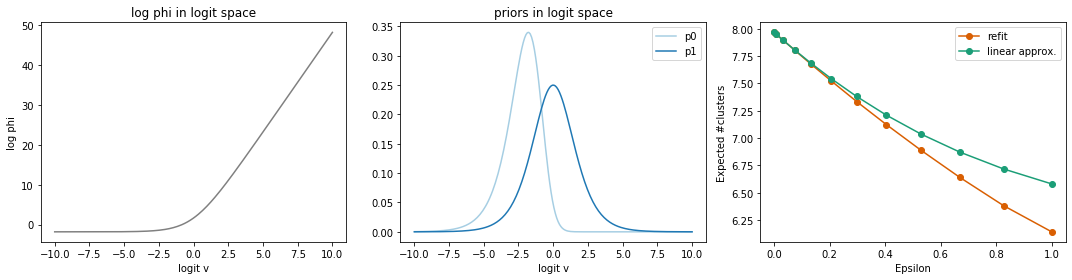

In [19]:
plot_stuff('alpha_pert_neg');